In [278]:
# Use GPU
import os
import requests
import json

import pandas as pd
import numpy as np
import torch
import seaborn as sns
import math

from torch.utils.data import DataLoader, TensorDataset

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset

from tqdm.notebook import tqdm

from IPython.display import display, clear_output

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

from scipy.sparse import hstack

from matplotlib import pyplot as plt

In [77]:
pd.set_option('display.max_rows',50)

In [78]:
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [79]:
df_train = pd.read_csv('./data/original_dataset/train.csv')
df_test = pd.read_csv('./data/original_dataset/test.csv')

In [80]:
display(df_train.info())
display(df_train.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


None

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


### Rename columns
- Lets temporarily rename the columns to make interpretation a bit easier

In [81]:
df_train = df_train.rename(columns={'target': 'Disaster'})
df_test = df_test.rename(columns={'target': 'Disaster'})

df_train = df_train.rename(columns={'text': 'Tweet'})
df_test = df_test.rename(columns={'text': 'Tweet'})

df_train = df_train.rename(columns={'location': 'TweetLocation'})
df_test = df_test.rename(columns={'location': 'TweetLocation'})

df_train = df_train.rename(columns={'keyword': 'TweetKeywords'})
df_test = df_test.rename(columns={'keyword': 'TweetKeywords'})

In [82]:
display("Missing values")
display(df_train.isna().sum())

'Missing values'

id                  0
TweetKeywords      61
TweetLocation    2533
Tweet               0
Disaster            0
dtype: int64

**Observation:**
- We can see that locations and keywords are not present for many obvious tweets. Lots of cleaning could fix this.

### Baseline-run
- Before we try in-depth cleaning and processing, lets see what kind of performance we can get using the data alone

In [ ]:
vectorizer = CountVectorizer()
X_tweet = vectorizer.fit_transform(df_train['Tweet'])
X_tweetkeywords = vectorizer.transform(df_train['TweetKeywords'].fillna("None"))
X_tweetlocation = vectorizer.transform(df_train['TweetLocation'].fillna("None"))
X = hstack([X_tweet, X_tweetkeywords, X_tweetlocation])
y = df_train['Disaster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
print(f"Accuracy Score w/ all features: {accuracy_score(model.predict(X_test),y_test)}")

vectorizer = CountVectorizer()
X_tweet = vectorizer.fit_transform(df_train['Tweet'])
X_tweetkeywords = vectorizer.transform(df_train['TweetKeywords'].fillna("None"))
X_tweetlocation = vectorizer.transform(df_train['TweetLocation'].fillna("None"))
X = hstack([X_tweet])
y = df_train['Disaster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)
print(f"Accuracy Score w/ just tweets: {accuracy_score(model.predict(X_test),y_test)}")

We see with logistic regression, we get a baseline accuracy of ~81% without any cleaning and only using the tweet column or all features.

### Engineer basic features
- Lets try to engineer some new features

#### Create new feature 'ContainsMention'

In [83]:
df_train['ContainsMention'] = df_train['Tweet'].str.contains('@')
df_test['ContainsMention'] = df_test['Tweet'].str.contains('@')

In [84]:
df_train[df_train['ContainsMention'] == True].sample(2)

,id,TweetKeywords,TweetLocation,Tweet,Disaster,ContainsMention
4734,6731,lava,"Bandar Lampung, Indonesia",@YoungHeroesID Lava Blast dan Power Red #Panth...,1,True
1195,1721,buildings%20burning,NaN,@SonofLiberty357 all illuminated by the bright...,0,True


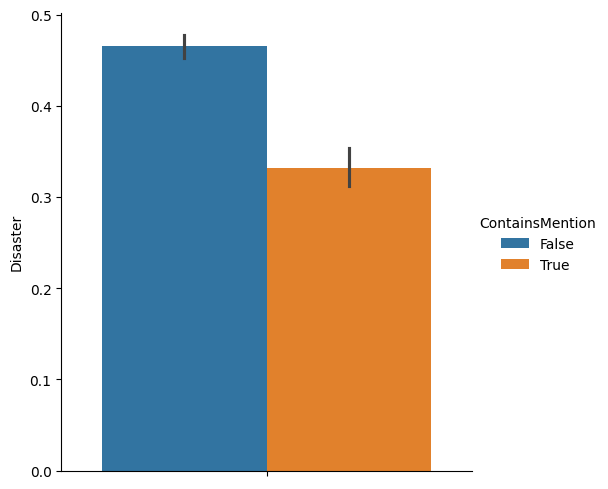

In [85]:
sns.catplot(hue='ContainsMention',y='Disaster',data=df_train,kind='bar')

- We can see that tweets with mentions '@' are less likely to be related to a disaster.

#### Create new feature 'ContainsUrl'

In [86]:
df_train['ContainsUrl'] = df_train['Tweet'].str.contains(r'http|https|www\.|t\.co', regex=True)
df_test['ContainsUrl'] = df_test['Tweet'].str.contains(r'http|https|www\.|t\.co', regex=True)

In [87]:
df_train[df_train['ContainsUrl'] == True].sample(2)

,id,TweetKeywords,TweetLocation,Tweet,Disaster,ContainsMention,ContainsUrl
6725,9638,thunderstorm,NaN,RT @LivingSafely: NWS posts Severe #Thundersto...,1,True,True
2554,3662,destroy,"Jerseyville, IL",Dem FLATLINERS who destroy creativity-balance-...,1,False,True


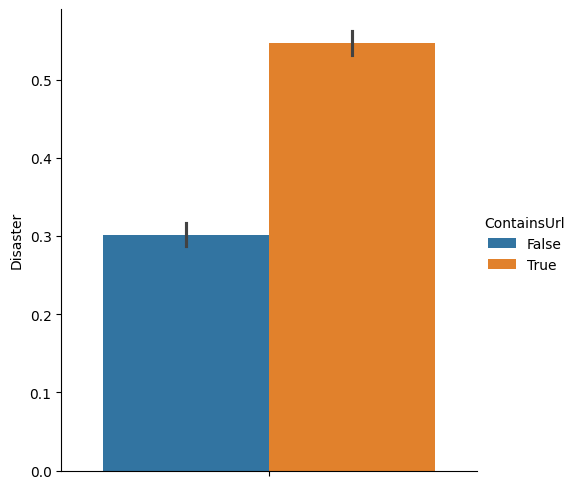

In [88]:
sns.catplot(hue='ContainsUrl',y='Disaster',data=df_train,kind='bar')

- We can see presence of a URL is much more likely to be a disaster tweet.

Lets quickly make sure we didn't miss any types of links.

In [89]:
# Check to see if we've missed any links
df_train[df_train['ContainsUrl'] == False]['Tweet'].values.tolist()

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

In [90]:
df_train.isna().sum()

id                    0
TweetKeywords        61
TweetLocation      2533
Tweet                 0
Disaster              0
ContainsMention       0
ContainsUrl           0
dtype: int64

### Benchmark model again
- Lets see how the model performs with the new engineered features

In [ ]:
vectorizer = CountVectorizer()

X_tweet = vectorizer.fit_transform(df_train['Tweet'])
X_keyword = vectorizer.transform(df_train['TweetKeywords'].fillna('None'))
X_location = vectorizer.transform(df_train['TweetLocation'].fillna('None'))

encoder = OneHotEncoder()
X_onehot = encoder.fit_transform(df_train[['ContainsUrl', 'ContainsMention']])

X = hstack([X_tweet, X_keyword, X_location, X_onehot])
y = df_train['Disaster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict and Evaluate
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

The performance is actually worse than before.

(Not shown here, but I also attempted representing text data using word embeddings and contextual embeddings. The results were mostly the same, which indicates we are limited by our model here. We need a model that can better model the complexity of text data, so we will look to LLMs or NLP models here. Lets start with BERT.)

#### Lets try training a model on just the URL and ContainsMention features alone.

In [129]:
X = pd.get_dummies(df_train[['ContainsMention', 'ContainsUrl']],columns=['ContainsMention', 'ContainsUrl'])
y = df_train['Disaster']

print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
log_reg = RandomForestClassifier()
log_reg.fit(X_train, y_train)

# Predict and Evaluate
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Index(['ContainsMention_False', 'ContainsMention_True', 'ContainsUrl_False',
       'ContainsUrl_True'],
      dtype='object')
Accuracy: 0.6349310571240971


#### Just tweet location

In [155]:
vectorizer = CountVectorizer()

X_tweet_location = vectorizer.fit_transform(df_train['TweetLocation'].fillna("N/A"))

X = X_tweet_location
y = df_train['Disaster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict and Evaluate
y_pred = log_reg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5988181221273802


### BERT
- Lets try using a more complex model to help df_train['TweetLocation'].values.tolist()

#### Only text feature

In [203]:
df_train_0 = df_train.copy()
df_test_0 = df_test.copy()

df_train_0 = df_train_0[['Tweet','Disaster']].rename(columns={'Tweet': 'text', 'Disaster': 'label'})
df_test_0 = df_test_0[['Tweet']].rename(columns={'Tweet': 'text'})

df_train_0.to_csv('./data/training_datasets/tweet/train.csv',index=False)
df_test_0.to_csv('./data/training_datasets/tweet/test.csv',index=False)

#### Include location in tweet

In [206]:
df_train_1 = df_train.copy()
df_test_1 = df_test.copy()

df_train_1['TweetLocation'] = df_train_1['TweetLocation'].fillna('N/A')
df_test_1['TweetLocation'] = df_test_1['TweetLocation'].fillna('N/A')

df_train_1['TweetWithLocation'] = df_train_1.apply(lambda row: f'Location: {row["TweetLocation"]} Tweet: {row["Tweet"]}', axis=1)
df_test_1['TweetWithLocation'] = df_test_1.apply(lambda row: f'Location: {row["TweetLocation"]} Tweet: {row["Tweet"]}', axis=1)

df_train_1 = df_train_1[['TweetWithLocation', 'Disaster']].rename(columns={'TweetWithLocation': 'text', 'Disaster': 'label'})
df_test_1 = df_test_1[['TweetWithLocation']].rename(columns={'TweetWithLocation': 'text'})

df_train_1.to_csv('./data/training_datasets/tweet+location/train.csv',index=False)
df_test_1.to_csv('./data/training_datasets/tweet+location/test.csv',index=False)

# (See script.py for training code)

In [298]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.load_state_dict(torch.load("./data/weights/model_weights_train_v1.0"))

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [299]:
class BERTDisasterClassifier(BertForSequenceClassification):
    def __init__(self, bert_model, tokenizer, hwd):
        super().__init__(bert_model.config)
        self.bert_model = bert_model
        self.tokenizer = tokenizer
        self.hwd = hwd
        self.bert_model.to(self.hwd)
        
    def _get_encodeds(self, texts):
        return self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    def predict(self, texts: list):
        encoded_input = self._get_encodeds(texts)
        input_ids = encoded_input['input_ids'].to(self.hwd)
        attention_mask = encoded_input['attention_mask'].to(self.hwd)
        self.bert_model.eval()
        with torch.no_grad():
            outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
        return predictions.cpu().numpy()

In [300]:
classifier = BERTDisasterClassifier(model, tokenizer, device)

In [301]:
# Desired batch size
batch_size = 32

num_items = len(df_train['Tweet'])
num_splits = math.ceil(num_items / batch_size)

# Use numpy.array_split to divide the tweets into batches
batches = np.array_split(df_test['Tweet'].values, num_splits)

predictions = np.concatenate([classifier.predict(batch.tolist()) for batch in batches])

In [302]:
df_test['target'] = predictions
submission_df = df_test[['id','target']]
submission_df.to_csv('./data/my_submission.csv',index=False)